### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Loading train and test dataset

In [2]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test = pd.read_csv("test.csv", parse_dates=["date"])

### Combine train and test dataset
The reason for doing this is to perform the operations to be performed on the dataset together and then separate it again as train and test.

In [3]:
df = pd.concat([train, test], sort=False)
df.head()

,date,store,item,sales,id
0,2013-01-01,1,1,13.0,NaN
1,2013-01-02,1,1,11.0,NaN
2,2013-01-03,1,1,14.0,NaN
3,2013-01-04,1,1,13.0,NaN
4,2013-01-05,1,1,10.0,NaN


### Checking missing values

In [4]:
df.isnull().sum()

,0
date,0
store,0
item,0
sales,45000
id,913000


There is 45000 missing values in the sales column. I explain the reason for this. Our dependent variable, that is, our target value, is the sales column. And this column is not included in the test data set. We combined the train and test set and we encountered 45000 missing values because there is no sales column in the test set. There are 913000 missing values in the ID column. This is because it is in the test set but not in the train set.

--------------------------------------------------------------------------------------------------------------------------------------------------------

In [5]:
print(f"Store sequence number ---> {df['store'].unique()}\nTotal number of stores ---> {df['store'].nunique()}")
print("---------------------------------------------------------------------------------------------------")
print(f"Item sequence number ---> {df['item'].unique()}\nTotal number of item ---> {df['item'].nunique()}")

Store sequence number ---> [ 1  2  3  4  5  6  7  8  9 10]
Total number of stores ---> 10
---------------------------------------------------------------------------------------------------
Item sequence number ---> [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
Total number of item ---> 50


In [6]:
for key,value in dict(df.groupby(["store"])["item"].nunique()).items():
    print(f"{key}.store ---> {value} unique items")

1.store ---> 50 unique items
2.store ---> 50 unique items
3.store ---> 50 unique items
4.store ---> 50 unique items
5.store ---> 50 unique items
6.store ---> 50 unique items
7.store ---> 50 unique items
8.store ---> 50 unique items
9.store ---> 50 unique items
10.store ---> 50 unique items


Each store sells 50 unique products. This means that the stores compete with each other. That is, each of them participates in the sale of each of the 50 items in the dataset.

In [7]:
df.groupby(["store", "item"]).agg({"sales":["sum"]})

sales
                 sum
store item          
1     1      36468.0
      2      97050.0
      3      60638.0
      4      36440.0
      5      30335.0
...              ...
10    46    120601.0
      47     45204.0
      48    105570.0
      49     60317.0
      50    135192.0

[500 rows x 1 columns]

The result of this code tells us how many of each item is sold in each store.

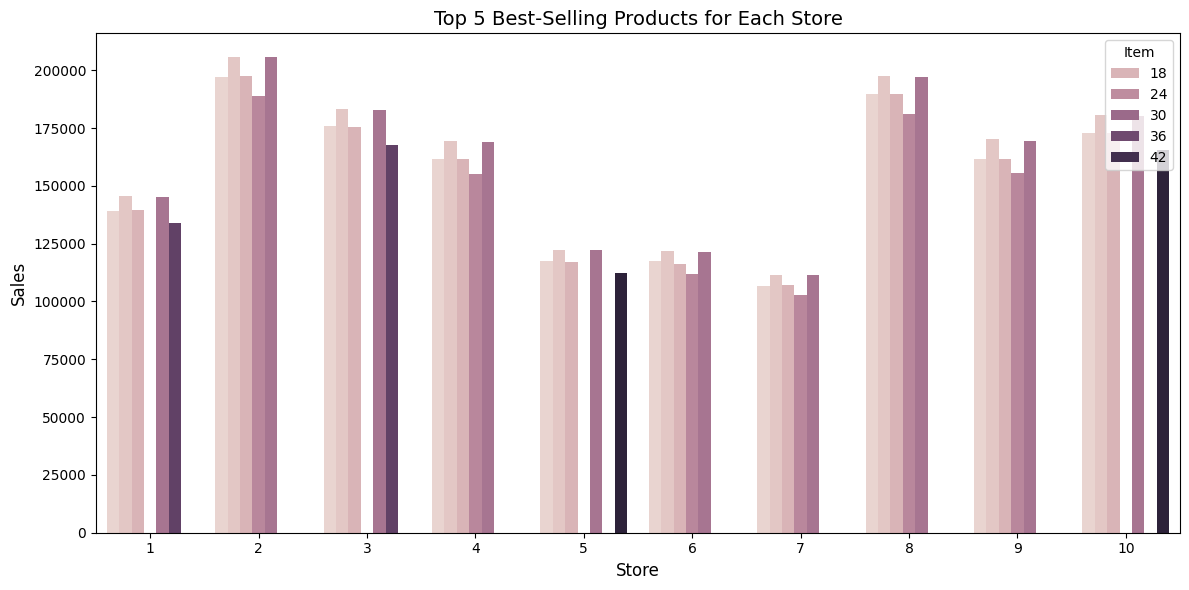

In [8]:
grouped_df = df.groupby(["store", "item"]).agg({"sales": "sum"}).reset_index()

top_5_per_store = (
    grouped_df.sort_values(by=["store", "sales"], ascending=[True, False])
    .groupby("store")
    .head(5)
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=top_5_per_store,
    x="store",
    y="sales",
    hue="item",
    dodge=True
)
plt.title("Top 5 Best-Selling Products for Each Store", fontsize=14)
plt.xlabel("Store", fontsize=12)
plt.ylabel("Sales", fontsize=12)
plt.legend(title="Item", loc="upper right")
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

This visual gives us information about the 5 best-selling products in each store.

### Date Feature Engineering Function

In [9]:
def create_date_features(data):

    df['month'] = df.date.dt.month
    df['day_of_month'] = df.date.dt.day
    df['day_of_year'] = df.date.dt.dayofyear
    df['day_of_week'] = df.date.dt.dayofweek
    df['year'] = df.date.dt.year
    df["is_wknd"] = df.date.dt.weekday // 4
    df['is_month_start'] = df.date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.date.dt.is_month_end.astype(int)

    return data

df = create_date_features(data=df)

This code defines a function called create_date_features that extracts several useful features from a date column in a given dataset. The function adds new columns to the DataFrame, enriching it with temporal information. These features can be useful for time series analysis or predictive modeling.

Key Features Created:

* month: The month extracted from the date column.
* day_of_month: The day of the month.
* day_of_year: The day of the year.
* day_of_week: The day of the week (0 = Monday, 6 = Sunday).
* year: The year extracted from the date column.
* is_wknd: Indicates whether the day is part of the weekend (1 = weekend, 0 = weekday).
* is_month_start: A binary indicator for the first day of the month.
* is_month_end: A binary indicator for the last day of the month.

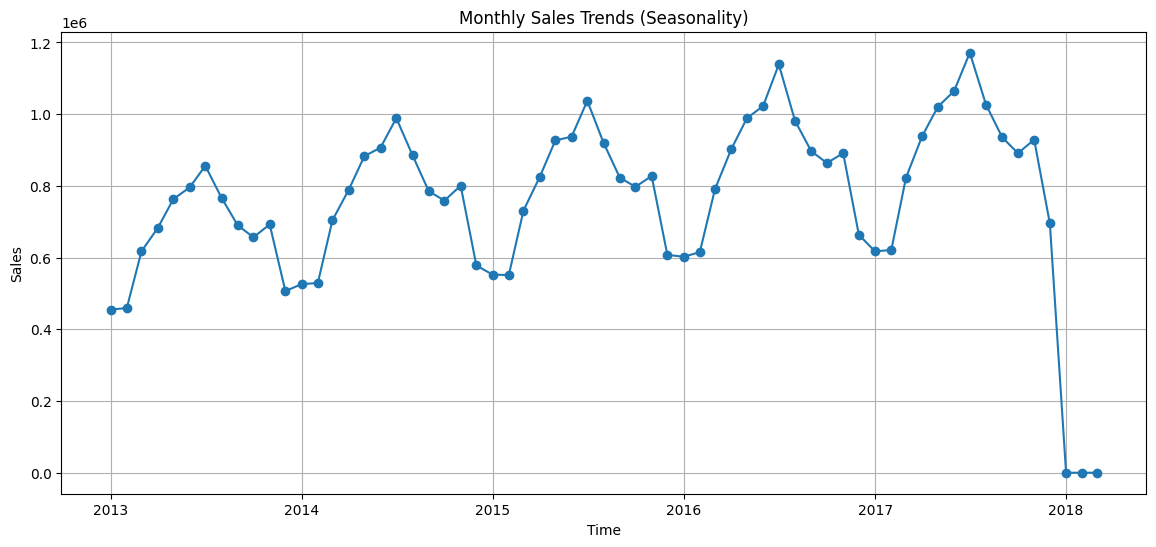

In [10]:
monthly_sales = df.groupby(['year', 'month'])['sales'].sum().reset_index()
monthly_sales['year_month'] = pd.to_datetime(monthly_sales['year'].astype(str) + '-' + monthly_sales['month'].astype(str))

plt.figure(figsize=(14, 6))
plt.plot(monthly_sales['year_month'], monthly_sales['sales'], marker='o')
plt.title("Monthly Sales Trends (Seasonality)")
plt.xlabel("Time")
plt.ylabel("Sales")
plt.grid()
plt.show()

This code performs an analysis of monthly sales trends to identify seasonality or patterns in sales data over time.

The line chart shows monthly sales trends over several years. Key observations include:

* Seasonality: The sales exhibit a recurring pattern over time, peaking and dropping around specific months each year. This indicates seasonality, which is a common characteristic in sales data.

* Year-to-Year Consistency: The pattern of sales peaks and troughs is consistent across the years. This suggests external factors like holidays, promotions, or seasonal demand likely drive these fluctuations.

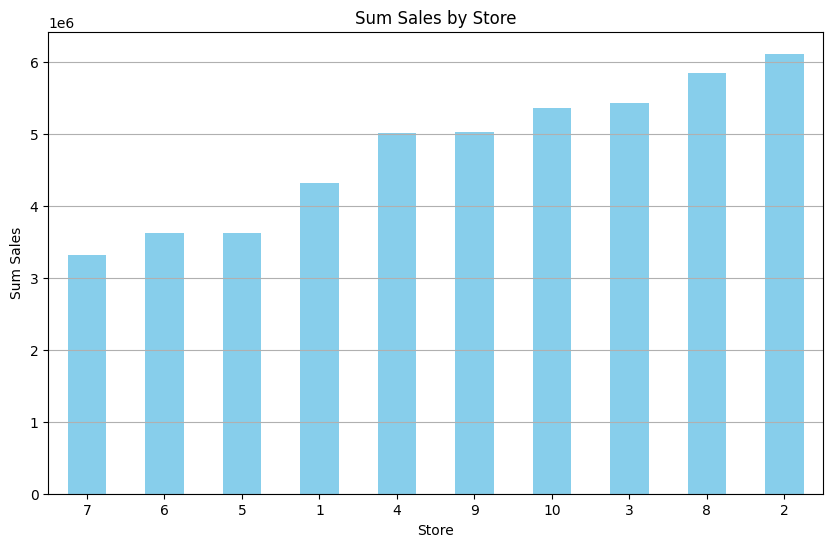

In [11]:
store_sales = df.groupby('store')['sales'].sum().sort_values()

plt.figure(figsize=(10, 6))
store_sales.plot(kind='bar', color='skyblue')
plt.title("Sum Sales by Store")
plt.xlabel("Store")
plt.ylabel("Sum Sales")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()


The visual shows the order of the most sales among the stores. This is an important issue for us. As you can see from the visual, the store with the highest sales is the store with the number 2.

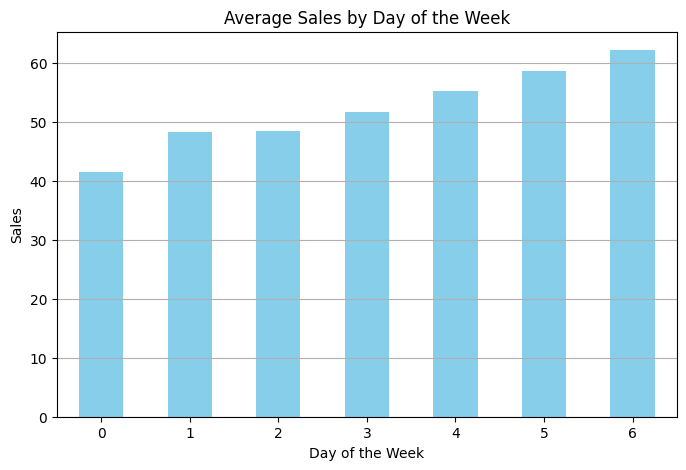

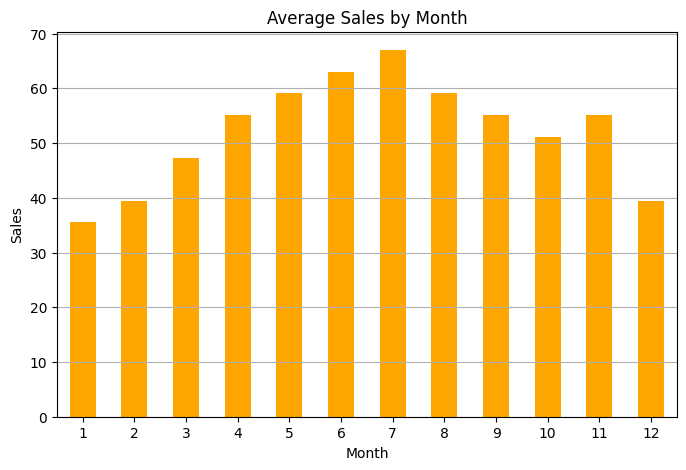

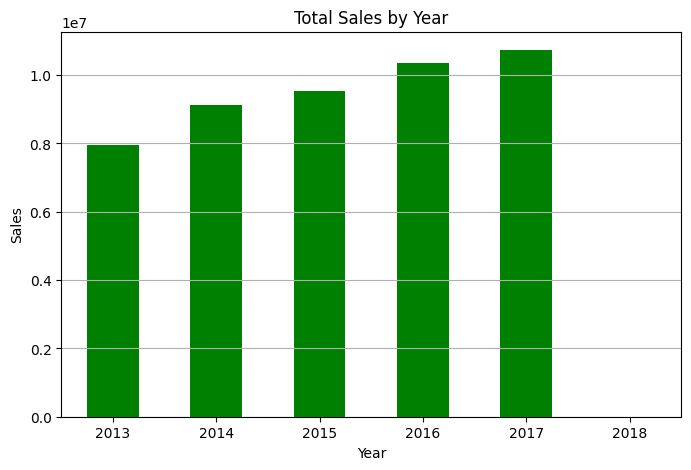

In [12]:
sales_by_day = df.groupby('day_of_week')['sales'].mean()
sales_by_month = df.groupby('month')['sales'].mean()
sales_by_year = df.groupby('year')['sales'].sum()

plt.figure(figsize=(8, 5))
sales_by_day.plot(kind='bar', color='skyblue')
plt.title("Average Sales by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Sales")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(8, 5))
sales_by_month.plot(kind='bar', color='orange')
plt.title("Average Sales by Month")
plt.xlabel("Month")
plt.ylabel("Sales")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

plt.figure(figsize=(8, 5))
sales_by_year.plot(kind='bar', color='green')
plt.title("Total Sales by Year")
plt.xlabel("Year")
plt.ylabel("Sales")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()


1. Average Sales by Day of the Week

* Sales steadily increase as the week progresses.
* The highest sales occur on day 6 (Sunday), while the lowest sales are on day 0 (Monday).

2. Average Sales by Month

* Sales show a clear seasonal trend, peaking in July.
* A significant increase in sales is visible between spring (March-May) and summer (June-July), followed by a gradual decline in the later months of the year.

3. Total Sales by Year

* Total sales steadily increased from 2013 to 2017, indicating consistent business growth.
* The highest sales were recorded in 2016 and 2017, with a slight plateau during these years.

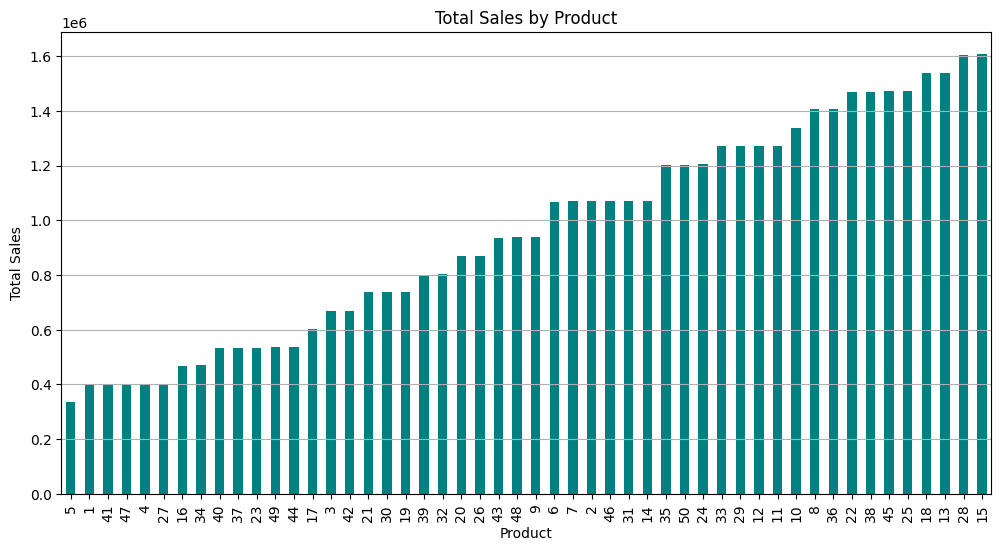

In [13]:
product_sales = df.groupby('item')['sales'].sum().sort_values()

plt.figure(figsize=(12, 6))
product_sales.plot(kind='bar', color='teal')
plt.title("Total Sales by Product")
plt.xlabel("Product")
plt.ylabel("Total Sales")
plt.grid(axis='y')
plt.show()


This visual shows the order of sale of the products. As can be seen from the visual, the most sold item is item number 15.

--------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
def random_noise(data):
    return np.random.normal(scale=1.6, size=(len(data)))

For example, if we want to predict tomorrow's sales value, we do not add past actual values to the dataset to find this value. These past values may change according to the situation. For example, in this project, I added 91, 98, 105, 112, 119, 126, 182, 364, 546, 728 days ago to my dataset. And we add noises on it so that it is not the same values. This function is for creating these noises.


### Lag/Shifted Features


In [15]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["store", "item"])['sales'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

In [16]:
df = lag_features(dataframe=df, lags=[91, 98, 105, 112, 119, 126, 182, 364, 546, 728])


### Rolling Mean Features

In [17]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby(["store", "item"])['sales']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe


In [18]:
df = roll_mean_features(df, [365, 546])

### Exponentially Weighted Mean Features


In [19]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store", "item"])['sales'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91, 98, 105, 112, 180, 270, 365, 546, 728]

df = ewm_features(df, alphas, lags)

In [20]:
df = pd.get_dummies(df, columns=["store", "item", "day_of_week", "month" ])

In [21]:
df["sales"] = np.log1p(df["sales"].values)

### Custom Cost Function


In [22]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val


In [23]:
def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

### Time-Based Validation Sets


In [24]:
train = df.loc[(df["date"] < "2017-01-01"), :]

val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ['date', 'id', "sales", "year"]]

Y_train = train['sales']
X_train = train[cols]

Y_val = val['sales']
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 141), (45000,), (45000, 141))

In [25]:
# LightGBM parameters
lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 10000,
              'early_stopping_rounds': 200,
              'nthread': -1}

### Modeling

In [ ]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(
    lgb_params,
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=lgb_params['num_boost_round'],
    callbacks=[
        early_stopping(stopping_rounds=lgb_params['early_stopping_rounds']),
        lgb.log_evaluation(period=100)
    ],
    feval=lgbm_smape
)

y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

smape(np.expm1(y_pred_val), np.expm1(Y_val))

Training until validation scores don't improve for 200 rounds
[100]	training's l2: 0.0512828	training's SMAPE: 17.5887	valid_1's l2: 0.0532906	valid_1's SMAPE: 17.4966
[200]	training's l2: 0.0352326	training's SMAPE: 14.5714	valid_1's l2: 0.0372081	valid_1's SMAPE: 14.9154
[300]	training's l2: 0.0324373	training's SMAPE: 14.0144	valid_1's l2: 0.0341897	valid_1's SMAPE: 14.4335
[400]	training's l2: 0.0313875	training's SMAPE: 13.8081	valid_1's l2: 0.0333517	valid_1's SMAPE: 14.2838
[500]	training's l2: 0.0307123	training's SMAPE: 13.6745	valid_1's l2: 0.0327511	valid_1's SMAPE: 14.1511
[600]	training's l2: 0.0302705	training's SMAPE: 13.5822	valid_1's l2: 0.0322611	valid_1's SMAPE: 14.0346
[700]	training's l2: 0.0299224	training's SMAPE: 13.5129	valid_1's l2: 0.0319693	valid_1's SMAPE: 13.9673
[800]	training's l2: 0.0296228	training's SMAPE: 13.4532	valid_1's l2: 0.0317561	valid_1's SMAPE: 13.9158
[900]	training's l2: 0.0293963	training's SMAPE: 13.4054	valid_1's l2: 0.0315695	valid_1's

13.523551832672485

                        feature  split       gain
16          sales_roll_mean_546   7386  57.642786
12                sales_lag_364   6109  12.794331
15          sales_roll_mean_365   5194   8.524606
59   sales_ewm_alpha_05_lag_365   1858   4.585564
1                   day_of_year   5984   3.091507
..                          ...    ...        ...
73                       item_2     51   0.000266
102                     item_31     31   0.000258
3                is_month_start     23   0.000236
132                     month_4     14   0.000102
119                     item_48     11   0.000090

[141 rows x 3 columns]


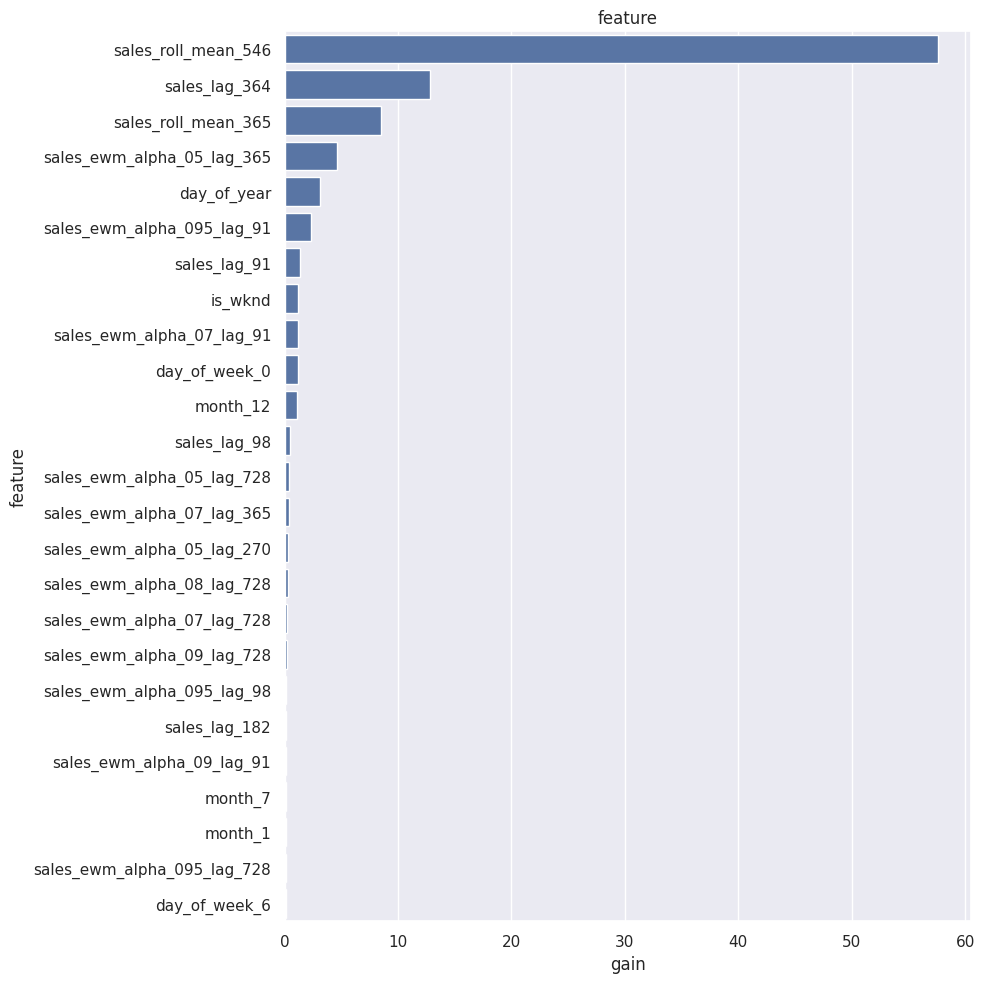

                        feature  split       gain
16          sales_roll_mean_546   7386  57.642786
12                sales_lag_364   6109  12.794331
15          sales_roll_mean_365   5194   8.524606
59   sales_ewm_alpha_05_lag_365   1858   4.585564
1                   day_of_year   5984   3.091507
..                          ...    ...        ...
73                       item_2     51   0.000266
102                     item_31     31   0.000258
3                is_month_start     23   0.000236
132                     month_4     14   0.000102
119                     item_48     11   0.000090

[141 rows x 3 columns]


141

In [27]:
def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

plot_lgb_importances(model, num=200)

plot_lgb_importances(model, num=30, plot=True)


feat_imp = plot_lgb_importances(model, num=200)

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values

imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

In [35]:
train = df.loc[~df.sales.isna()]
Y_train = train['sales']
X_train = train[cols]


test = df.loc[df.sales.isna()]
X_test = test[cols]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)

final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)



test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)